In [1]:
%matplotlib inline
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
pd.options.display.max_rows = 200

plt.rcParams['figure.figsize'] = [20, 10]
plt.rc('font', size=20)



# Loading Dataset

## IOT Devices

The dataset has been extracted at `ROOT_PATH`, containing the data for each IOT device. There are 9 devices in total. There are folders for each IOT device containing `benign_traffic.csv` and further two folders for `gafgyt_attacks` and `mirai_attacks`

In [3]:
ROOT_PATH = r'C:\Users\jessm\Desktop\HonoursProject\N-BaIoT_Dataset'
IOT_DEVS = [ 'Danmini_Doorbell',
             'Ecobee_Thermostat',
           # 'Ennio_Doorbell',
             'Philips_Baby_Monitor',
             '737E_Security_Cam',
            '838_Security_Cam',
           #  'Samsung_Webcam',
             '1002_Security_Cam',
             '1003_Security_Cam'
           ]

## Paths to CSVs
We create a python dictionary that contains all the paths to the CSVs for the respective IOT devices

In [4]:
PATHS_DICT = {}

for i in IOT_DEVS:
    PATHS_DICT[i] = {}
    print('[' + i + ']')
    iot_dir = os.path.join(ROOT_PATH, i)
    PATHS_DICT[i]['benign'] = os.path.join(iot_dir, 'benign_traffic.csv')
    print('  ', 'benign_traffic.csv')
    attacks = [ d for d in os.listdir(iot_dir)
                   if os.path.isdir( os.path.join(iot_dir, d)) ]
    for attack in attacks:
        attack_name = attack.split('_')[0]
        
        PATHS_DICT[i][attack_name] = {}
        attack_dir = os.path.join(iot_dir, attack)
        types = [ f for f in os.listdir(attack_dir)
                   if os.path.isfile( os.path.join(attack_dir, f)) ]
        print('  ', attack_name, ': ', types)
        for t in types:
            type_name = t.split('.')[0]
            PATHS_DICT[i][attack_name][type_name] = os.path.join(attack_dir,t)

[Danmini_Doorbell]
   benign_traffic.csv
   gafgyt :  ['combo.csv', 'junk.csv', 'scan.csv', 'tcp.csv', 'udp.csv']
   mirai :  ['ack.csv', 'scan.csv', 'syn.csv', 'udp.csv', 'udpplain.csv']
[Ecobee_Thermostat]
   benign_traffic.csv
   gafgyt :  ['combo.csv', 'junk.csv', 'scan.csv', 'tcp.csv', 'udp.csv']
   mirai :  ['ack.csv', 'scan.csv', 'syn.csv', 'udp.csv', 'udpplain.csv']
[Philips_Baby_Monitor]
   benign_traffic.csv
   gafgyt :  ['combo.csv', 'junk.csv', 'scan.csv', 'tcp.csv', 'udp.csv']
   mirai :  ['ack.csv', 'scan.csv', 'syn.csv', 'udp.csv', 'udpplain.csv']
[737E_Security_Cam]
   benign_traffic.csv
   gafgyt :  ['combo.csv', 'junk.csv', 'scan.csv', 'tcp.csv', 'udp.csv']
   mirai :  ['ack.csv', 'scan.csv', 'syn.csv', 'udp.csv', 'udpplain.csv']
[838_Security_Cam]
   benign_traffic.csv
   gafgyt :  ['combo.csv', 'junk.csv', 'scan.csv', 'tcp.csv', 'udp.csv']
   mirai :  ['ack.csv', 'scan.csv', 'syn.csv', 'udp.csv', 'udpplain.csv']
[1002_Security_Cam]
   benign_traffic.csv
   gafgyt : 

## Loading CSVs into Pandas
We will create pandas dataframe for each botnet attack across all IOT devices. For each datafram we will combine the attack traffic with the benign traffic add the following two columns:
- `traffic_type` : benign or attack (0 or 1)
- `attack_type`  : type of attack e.g, ack, scan etc.

In [5]:
import pandas as pd

nbaiot_dict = {}

for iot_dev in PATHS_DICT:
    b_df = pd.read_csv(PATHS_DICT[iot_dev]['benign'])
    b_df['traffic_type'] = 'benign'
    b_df['attack_type'] = 'benign'
    
    for botnet in [b for b in PATHS_DICT[iot_dev] if b != 'benign']:
        if botnet not in nbaiot_dict:
            nbaiot_dict[botnet] = pd.DataFrame()
        
        # Concatenate benign data to the botnet's DataFrame
        nbaiot_dict[botnet] = pd.concat([nbaiot_dict[botnet], b_df], ignore_index=True)
        
        for attack in PATHS_DICT[iot_dev][botnet]:
            a_df = pd.read_csv(PATHS_DICT[iot_dev][botnet][attack])
            a_df['traffic_type'] = 'attack'
            a_df['attack_type'] = attack
            
            # Concatenate attack data to the botnet's DataFrame
            nbaiot_dict[botnet] = pd.concat([nbaiot_dict[botnet], a_df], ignore_index=True)


In [6]:
for k in nbaiot_dict:
    print(k,':','<benign+attack>')

gafgyt : <benign+attack>
mirai : <benign+attack>


In [7]:
nbaiot_dict['gafgyt'].shape

(2663482, 117)

In [8]:
nbaiot_dict['mirai'].shape

(4133084, 117)

In [9]:
nbaiot_dict['gafgyt']['traffic_type'].value_counts()

attack    2198800
benign     464682
Name: traffic_type, dtype: int64

In [10]:
nbaiot_dict['mirai']['traffic_type'].value_counts()

attack    3668402
benign     464682
Name: traffic_type, dtype: int64

# Modeling

### Pre processing
Convert the target column `traffic_type` to integer 0 = benigh, 1 = attack 

In [11]:
for botnet in nbaiot_dict:
    nbaiot = nbaiot_dict[botnet]

    nbaiot.loc[ nbaiot['traffic_type']=='attack','traffic_type' ]=1
    nbaiot.loc[ nbaiot['traffic_type']=='benign','traffic_type' ]=0
    nbaiot['traffic_type'] = nbaiot['traffic_type'].astype(int)

    nbaiot_dict[botnet] = nbaiot

### Classifiers and training functions

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [13]:
classfiers = {
    'KNN' : KNeighborsClassifier(),
    'RFR' : RandomForestClassifier(),
    'DTR' : DecisionTreeClassifier(),
    'ADB' : AdaBoostClassifier(),
    
}

def train_test_report( X, y, test_size=0.33, avg='macro avg' ):

    X_train, X_test, y_train, y_test = train_test_split(
                                        X, y, test_size=0.33, random_state=42)

    result = []
    for clf_name in classfiers:
        clf = classfiers[clf_name]
        clf.fit(X_train, y_train)
        
        y_preds = clf.predict(X_test)
        
        clrp = classification_report(y_test, y_preds, output_dict=True)
        conf_mat = confusion_matrix(y_test, y_preds)
        fp = conf_mat[0][1]
        fn = conf_mat[1][0]
        
        result.append([
            clf_name,
            clrp['accuracy'],
            clrp[avg]['precision'],
            clrp[avg]['recall'],
            clrp[avg]['f1-score'],
            fp,
            fn
        ])

    return result

## Main Loop

In [14]:
all_results = [
    ['BOTNET', 'CLASSIFIER', 'ACCURACY', 'PRECISION', 'RECALL', 'F1-SCORE', 'FALSE-P', 'FALSE-N' ]
]

for botnet in nbaiot_dict:
    nbaiot = nbaiot_dict[botnet]

    print("================", botnet, "================")

    X = nbaiot.drop( ["attack_type", "traffic_type" ], axis=1 )
    y = nbaiot["traffic_type"]

    rep = train_test_report( X, y)
    for r in rep:
        print(r)
        all_results.append( [botnet] + r )

    print("================================================================")
    print("")


================ gafgyt ================
['KNN', 0.9988179077308151, 0.998885251372267, 0.9970007807640306, 0.9979400302424479, 885, 154]
['RFR', 0.9999988622788555, 0.9999993112985603, 0.9999967308937083, 0.9999980210905536, 1, 0]
['DTR', 0.9999863473462655, 0.9999814136440879, 0.999971092340113, 0.9999762529028107, 8, 4]
['ADB', 0.9999772455771091, 0.9999681623011543, 0.9999526807014896, 0.9999604213004226, 13, 7]

================ mirai ================
['KNN', 0.9960268872468873, 0.9928081384171855, 0.9871625190895552, 0.9899636840391911, 3710, 1709]
['RFR', 0.9999978004542796, 0.9999901900514041, 0.9999987613695949, 0.9999944756616144, 0, 3]
['DTR', 0.9999978004542796, 0.9999901900514041, 0.9999987613695949, 0.9999944756616144, 0, 3]
['ADB', 0.9999992668180931, 0.9999967299743631, 0.9999995871231984, 0.9999981585433488, 0, 1]



In [15]:
res_df =pd.DataFrame(all_results, index=None)

res_df, res_df.columns = res_df[1:] , res_df.iloc[0]

res_df

,BOTNET,CLASSIFIER,ACCURACY,PRECISION,RECALL,F1-SCORE,FALSE-P,FALSE-N
1,gafgyt,KNN,0.998818,0.998885,0.997001,0.99794,885,154
2,gafgyt,RFR,0.999999,0.999999,0.999997,0.999998,1,0
3,gafgyt,DTR,0.999986,0.999981,0.999971,0.999976,8,4
4,gafgyt,ADB,0.999977,0.999968,0.999953,0.99996,13,7
5,mirai,KNN,0.996027,0.992808,0.987163,0.989964,3710,1709
6,mirai,RFR,0.999998,0.99999,0.999999,0.999994,0,3
7,mirai,DTR,0.999998,0.99999,0.999999,0.999994,0,3
8,mirai,ADB,0.999999,0.999997,1.0,0.999998,0,1


In [16]:
# Write to csv
res_csv = res_df.to_csv(index=False)

print(res_csv, file=open('03_results.csv', 'w'))


### Load results from CSV

In [17]:
res_df = pd.read_csv('03_results.csv')

res_df = res_df[['BOTNET', 'CLASSIFIER', 'ACCURACY', 'PRECISION', 'FALSE-P', 'FALSE-N' ]]

res_df

,BOTNET,CLASSIFIER,ACCURACY,PRECISION,FALSE-P,FALSE-N
0,gafgyt,KNN,0.998818,0.998885,885,154
1,gafgyt,RFR,0.999999,0.999999,1,0
2,gafgyt,DTR,0.999986,0.999981,8,4
3,gafgyt,ADB,0.999977,0.999968,13,7
4,mirai,KNN,0.996027,0.992808,3710,1709
5,mirai,RFR,0.999998,0.999990,0,3
6,mirai,DTR,0.999998,0.999990,0,3
7,mirai,ADB,0.999999,0.999997,0,1


In [18]:
res_df.set_index(['BOTNET', 'CLASSIFIER'], inplace=True)
res_df

ACCURACY  PRECISION  FALSE-P  FALSE-N
BOTNET CLASSIFIER                                       
gafgyt KNN         0.998818   0.998885      885      154
       RFR         0.999999   0.999999        1        0
       DTR         0.999986   0.999981        8        4
       ADB         0.999977   0.999968       13        7
mirai  KNN         0.996027   0.992808     3710     1709
       RFR         0.999998   0.999990        0        3
       DTR         0.999998   0.999990        0        3
       ADB         0.999999   0.999997        0        1

<Axes: xlabel='BOTNET,CLASSIFIER'>

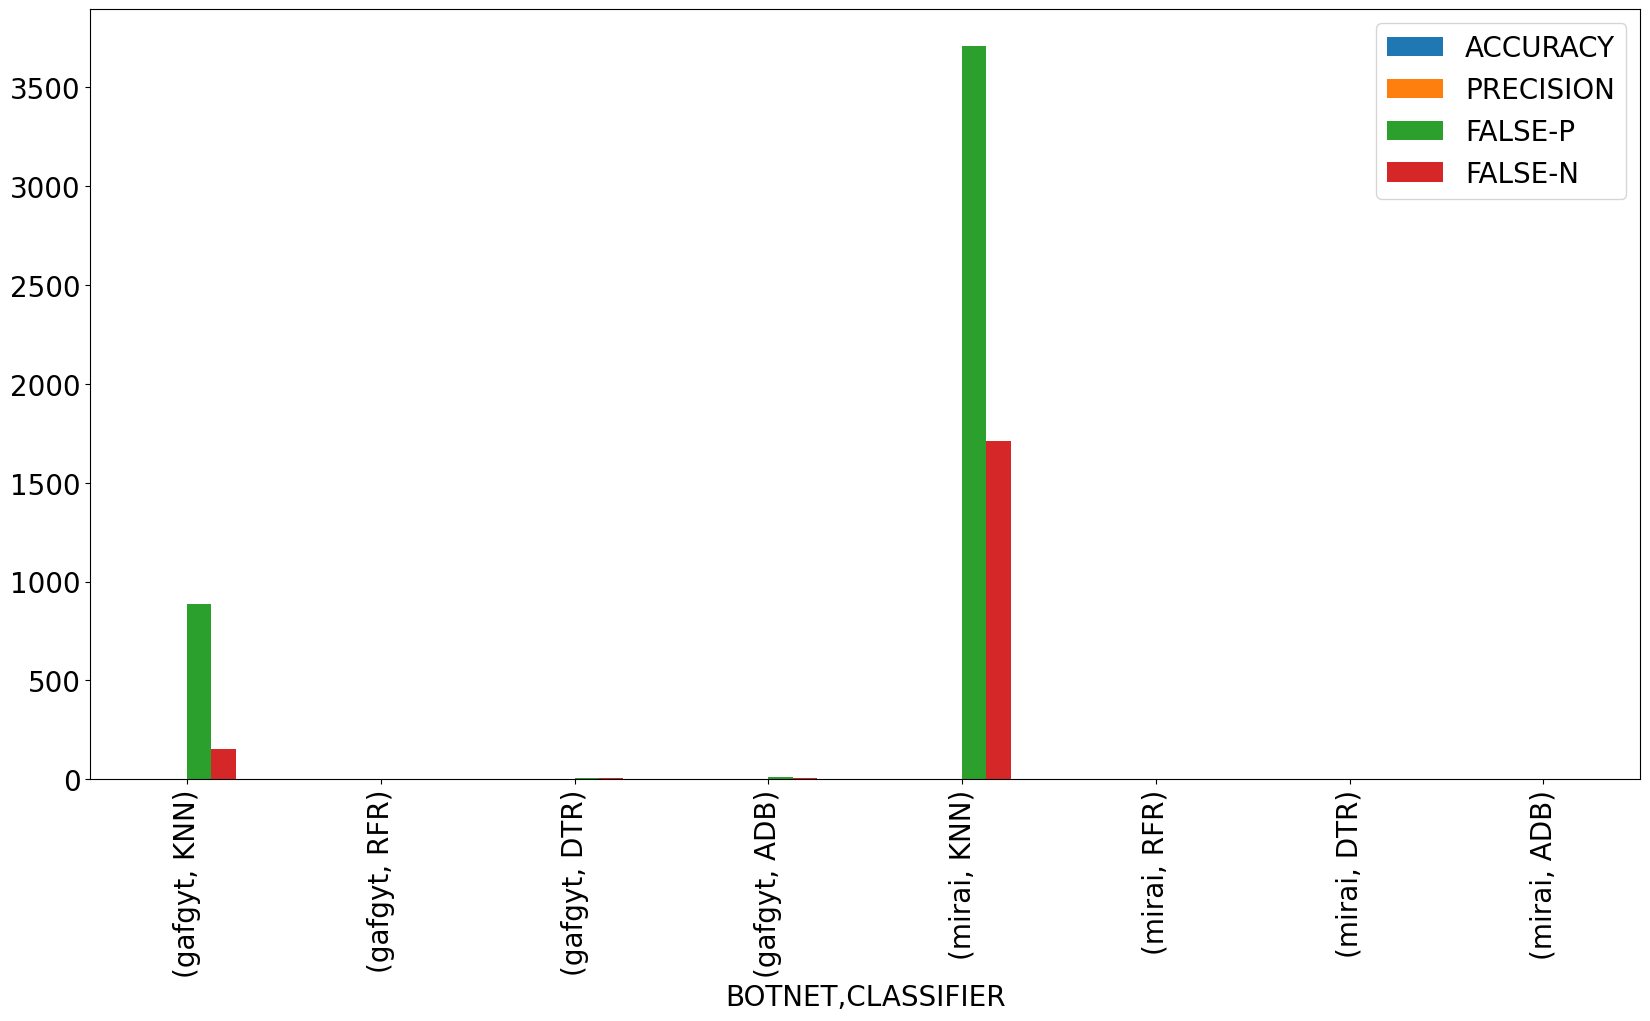

In [19]:
res_df.plot(kind='bar')

In [ ]:
print("hello")